<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_5_Data_Preparation_and_In_hospital_Mortality_Prediction_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7 Steps to Machine Learning

![7 Steps to Machine Learning](https://miro.medium.com/max/3000/0*V0GyOt3LoDVfY7y5.png)

1. **Data collection**. Machine learning requires a lot of training data to work, either labelled for supervised learning or unlabelled for unsupervised learning. If you are using MIMIC-III data, this step is equivalent to gaining access to the dataset.

2. **Data preparation**. Raw data alone isn't very useful. The data needs to be gathered, cleaned, normalized and errors and biases need to be removed before putting it into a model. Exploratory data analysis beforehand and visualisation of the data can be used to look for patterns and outliers to see if the right data has been collected or if data is missing. For supervised learning, the data would also need to be split into a training set and a testing data for training and evaluation purposes respectively. 

3. **Choosing a model**. There are many models that can be used for many different purposes, each with their strengths and limitations. The selection of the model should be based on the purpose of your decision support system or the research question in interest. In addition, it is important to perform any additional data preparation steps based on the chosen model. Commonly used machine learning algorithms for supervised learning include linear regression, logistic regression, decision trees, random forest, Support Vector Machines (SVM), Naïve Bayes and Neural Networks. All of these models are available to use within the Python package [Scikit-learn](https://scikit-learn.org/stable/user_guide.html). Note that a more complex model does not always yield a better model. 

4. **Training**. The objective of model training is to use your training data to iteratively improve model predictions by applying a machine learning algorithm. In supervised machine learning, the model is built using labelled sample data, while unsupervised machine learning tries to draw inferences from unlabelled data (without references to specific known or labelled outcomes).

5. **Evaluation**. This is to test the trained model against an unused testing dataset to see how it performs. Ideally, the testing set should be a close representative of how the model would work when deployed and used.

6. **Parameter tuning**. Each machine learning model inherently comes with several hyperparameters that you can tweak. After evaluating your model, you should try out different sets of hyperparameters in an attempt to improve the model. This is an experimental and iterative process.

7. **Prediction**
Once you have gone through the process of collecting data, preparing the data, selecting the model, training and evaluating the model and tuning the parameters, it can be used for predictions as a decision support system or to address your research questions.

# Example: In-hospital Mortality Prediction

## Objectives

As an example, we hypothesize that patients with a lot of interactions/events/encounters during a day in hospital tend to have a higher risk of mortality. Can we build a model that predicts in-hospital death based on those variables?

In machine learning terms, we are trying to build a binary classification model using supervised learning. 

First, let's load up libraries and authenticate ourselves.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Data Preparation: Gathering Data

In this step, we sought to gather all relevant information for each hospital stay across several tables in MIMIC-III. 

| Table | Variables to be extracted |
| --- | --- | 
| `admissions` | The basis of the table. <br>`SUBJECT_ID`, `HADM_ID`, `ADMISSION_TYPE`, <br>`ADMITTIME`, `DISCHTIME`, `DEATHTIME`, `HOSPITAL_EXPIRE_FLAG`, <br>`DIAGNOSIS`, `MARITAL_STATUS`,`INSURANCE`, `LANGUAGE`, `RELIGION`, `ETHNICITY` |
| `patients` | `GENDER`, `DOB` | 
| `icustays` | `LOS` |
| `labevents` | Number of events relating to laboratory tests | 
| `callouts` | Number of callouts of the patients |
| `prescriptions` | Number of prescriptions ordered | 
| `procedures_icd` | Number of procedures received | 
| `inputevents_cv`<br>`inputevents_mv` | Number of fluid input records |
| `outputevents` | Number of fluid output records |
| `diagnosis` | Number of diagnoses | 
| `transfers` | Number of transfers within hospital stay |
| `cptevents` | Number of events recorded in Current Procedural Terminology |
| `microbiologyevents` | Number of microbiology events or tests |

The SQL query for retrieving all these information is shown below, and can be broken down into two key steps:

* Calculate the event counts from each table listed above, except `admissions`, `patients` and `icustays`. Create alias for each of them using keywords `WITH` and `AS`.
* Link all the tables to the `admissions` table using `LEFT JOIN`, with `HADM_ID` or `SUBJECT_ID` as the common column. 

Note that you also can run it from your Bigquery console.


In [ ]:
%%bigquery --project your-project-id-here df
# make sure you change the project ID above!

WITH 
icustay AS (SELECT HADM_ID, SUM(LOS) AS LOS_ICU FROM `physionet-data.mimiciii_clinical.icustays` GROUP BY HADM_ID), 
callout AS (SELECT HADM_ID, COUNT(HADM_ID) AS CALLOUT_COUNT FROM  `physionet-data.mimiciii_clinical.callout` GROUP BY HADM_ID),
diags AS (SELECT HADM_ID, COUNT(HADM_ID) AS DIAG_COUNT FROM `physionet-data.mimiciii_clinical.diagnoses_icd` GROUP BY HADM_ID),
preps AS (SELECT HADM_ID, COUNT(HADM_ID) AS PRES_COUNT FROM `physionet-data.mimiciii_clinical.prescriptions` GROUP BY HADM_ID),
procs AS (SELECT HADM_ID, COUNT(HADM_ID) AS PROC_COUNT FROM `physionet-data.mimiciii_clinical.procedures_icd` GROUP BY HADM_ID),
cpts AS (SELECT HADM_ID, COUNT(HADM_ID) AS CPT_COUNT FROM `physionet-data.mimiciii_clinical.cptevents` GROUP BY HADM_ID),
labs AS (SELECT HADM_ID, COUNT(HADM_ID) AS LAB_COUNT FROM `physionet-data.mimiciii_clinical.labevents` GROUP BY HADM_ID),
inputs_cv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_CV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_cv` GROUP BY HADM_ID),
inputs_mv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_MV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_mv` GROUP BY HADM_ID),
outputs AS (SELECT HADM_ID, COUNT(HADM_ID) AS OUTPUT_COUNT FROM `physionet-data.mimiciii_clinical.outputevents` GROUP BY HADM_ID),
transfers AS (SELECT HADM_ID, COUNT(HADM_ID) AS TRANSFER_COUNT FROM `physionet-data.mimiciii_clinical.transfers` GROUP BY HADM_ID),
micros AS (SELECT HADM_ID, COUNT(HADM_ID) AS MICRO_COUNT FROM `physionet-data.mimiciii_clinical.microbiologyevents` GROUP BY HADM_ID)

SELECT adm.SUBJECT_ID, adm.HADM_ID, adm.ADMISSION_TYPE, 
adm.ADMITTIME, adm.DISCHTIME, adm.DEATHTIME, adm.HOSPITAL_EXPIRE_FLAG, 
adm.DIAGNOSIS, adm.MARITAL_STATUS, adm.INSURANCE, adm.LANGUAGE, adm.RELIGION, adm.ETHNICITY,
pts.GENDER, pts.DOB, 
icustay.LOS_ICU, callout.CALLOUT_COUNT, diags.DIAG_COUNT, preps.PRES_COUNT, procs.PROC_COUNT, cpts.CPT_COUNT, labs.LAB_COUNT, inputs_cv.INPUTS_CV_COUNT, inputs_mv.INPUTS_MV_COUNT, outputs.OUTPUT_COUNT, transfers.TRANSFER_COUNT, micros.MICRO_COUNT

FROM `physionet-data.mimiciii_clinical.admissions` AS adm
LEFT JOIN `physionet-data.mimiciii_clinical.patients` AS pts on adm.SUBJECT_ID = pts.SUBJECT_ID
LEFT JOIN icustay on adm.HADM_ID = icustay.HADM_ID
LEFT JOIN callout on adm.HADM_ID = callout.HADM_ID
LEFT JOIN diags on adm.HADM_ID = diags.HADM_ID
LEFT JOIN preps on adm.HADM_ID = preps.HADM_ID
LEFT JOIN procs on adm.HADM_ID = procs.HADM_ID
LEFT JOIN cpts on adm.HADM_ID = cpts.HADM_ID
LEFT JOIN labs on adm.HADM_ID = labs.HADM_ID
LEFT JOIN inputs_cv on adm.HADM_ID = inputs_cv.HADM_ID
LEFT JOIN inputs_mv on adm.HADM_ID = inputs_mv.HADM_ID
LEFT JOIN outputs on adm.HADM_ID = outputs.HADM_ID
LEFT JOIN transfers on adm.HADM_ID = transfers.HADM_ID
LEFT JOIN micros on adm.HADM_ID = micros.HADM_ID


Let's have a quick look of the gathered dataset.

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,NaN,18.0,NaN,3,47.0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,SINGLE,Government,None,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,NaN,9,NaN,9.0,NaN,408.0,331.0,NaN,89.0,3,27.0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,None,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,NaN,9,NaN,8.0,NaN,574.0,390.0,NaN,90.0,6,46.0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,NaN,21.0,20.0,4,NaN
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,NaN,22,53.0,6.0,10.0,378.0,165.0,NaN,115.0,7,5.0


In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'MARITAL_STATUS',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'CALLOUT_COUNT', 'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT',
       'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT',
       'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT'],
      dtype='object')

We could print some general information of dataframe using `.info()`

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            58976 non-null  int64         
 1   HADM_ID               58976 non-null  int64         
 2   ADMISSION_TYPE        58976 non-null  object        
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  58976 non-null  int64         
 7   DIAGNOSIS             58951 non-null  object        
 8   MARITAL_STATUS        48848 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  ETHNICITY             58976 non-null  object        
 13  GENDER          

By using `.isna().sum()`, we could see that there are missing values in several columns. 

In [ ]:
df.isna().sum()

SUBJECT_ID                  0
HADM_ID                     0
ADMISSION_TYPE              0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
HOSPITAL_EXPIRE_FLAG        0
DIAGNOSIS                  25
MARITAL_STATUS          10128
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
ETHNICITY                   0
GENDER                      0
DOB                         0
LOS_ICU                  1200
CALLOUT_COUNT           30244
DIAG_COUNT                  0
PRES_COUNT               8760
PROC_COUNT               6733
CPT_COUNT               14828
LAB_COUNT                 825
INPUTS_CV_COUNT         27006
INPUTS_MV_COUNT         37097
OUTPUT_COUNT             6968
TRANSFER_COUNT              0
MICRO_COUNT             10236
dtype: int64

## Data Preparation: Pre-processing Data

Now, we want to pre-process the data such that it is ready to be fed into a model. We also want to make variables that are useful for the model to learn from, a.k.a. feature engineering. There are 5 types of feature engineering:

* **Creating**. Create new features from existing ones if they provide additional value when predicting our outcome (e.g. creating age from date of birth and admission). 
* **Converting**. The raw dataset is most probably not ready for direct modelling. Some features need to be converted or normalized to meet the model input requirements. Usually, before we feed the training dataset into models, all datatypes need to be converted to numerical values for mathematical computation.
* **Completing**. Most models require no missing values in input variables in order to work. Model algorithms work best when there are no missing values. If missing values exist in the dataset, we may need to handle them either by (i) filling in any missing values through estimation; (ii) excluding the variable as an input; (iii) excluding the learning samples with any missing value present. 
* **Correcting**. We may also come across errors or inaccurate values within a dataset. Try to correct these values or exclude the samples with errors. One way to do this is to look out for any outliers among features.
* **Correlating**. Having redundant information within the input variable set would not help the model training process and could even lead to worse performances. Thus, one thing we can do is to perform basic statistical analysis. Which features within the dataset contribute significantly to our target variable? This can be tested both for numerical and categorical features in the given dataset.

### Creating

1. As `HOSPITAL_EXPIRE_FLAG` indicates in-hospital death (see [MIMIC's documentation](https://mimic.physionet.org/about/mimic/)), it will be our **prediction target**.<br>Let's rename the variable `HOSPITAL_EXPIRE_FLAG` into a more description one, `IN_HOSP_DEATH`. Also note that it is already numeric (either 1 or 0) and has no missing values, thus can be used as for model training.  



In [ ]:
df = df.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'IN_HOSP_DEATH'})

In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'IN_HOSP_DEATH', 'DIAGNOSIS', 'MARITAL_STATUS',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'CALLOUT_COUNT', 'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT',
       'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT',
       'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT'],
      dtype='object')

In [ ]:
df['IN_HOSP_DEATH'].isna().sum() # no missing value

0

In [ ]:
df['IN_HOSP_DEATH'].value_counts()

0    53122
1     5854
Name: IN_HOSP_DEATH, dtype: int64

2. We don't have a column indicating age, but can we calculate it based on 'DOB'(Date of birth) and 'ADMITTIME'.


In [ ]:
df['AGE'] = df['ADMITTIME'].sub(df['DOB']) // np.timedelta64(1,'Y') # subtract DOB from ADMITTIME and express difference in years 'Y'

df['AGE']

0         60
1         18
2         70
3       -285
4         76
        ... 
58971     38
58972     48
58973     33
58974     54
58975     41
Name: AGE, Length: 58976, dtype: int64

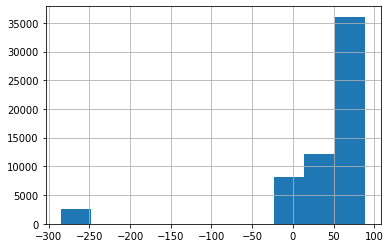

In [ ]:
df['AGE'].hist()

You may notice some weird negative values. We will address this later in the **Correcting** section.

3. Likewise, we can create a variable indicating hospital length of stay.

In [ ]:
df['LOS'] = df['DISCHTIME'].sub(df['ADMITTIME']) / np.timedelta64(1,'D') # subtract ADMITTIME from DISCHTIME and express difference in days 'D'

df['LOS']

0         4.164583
1        11.112500
2        13.895833
3         5.634722
4         5.585417
           ...    
58971     1.872917
58972     2.502083
58973     1.609722
58974     3.710417
58975     3.100000
Name: LOS, Length: 58976, dtype: float64

In [ ]:
df['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

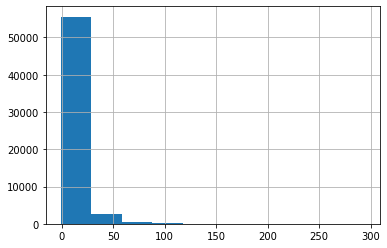

In [ ]:
df['LOS'].hist()

If you can think of any other variables that may be useful, feel free to add them by yourselves!

### Converting

The length of stay varies across patients, we may normalize the total count values into daily average count values in order to retrieve the frequency of the events. Here, we compute the values and save them as new columns, and append '_DAY' to the original column names.

In [ ]:
for col_name in ['CALLOUT_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name + '_DAY'] = df[col_name] / np.maximum(np.ceil(df['LOS']), 1)

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,NaN,18.0,NaN,3,47.0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.4,NaN,3.6,NaN,0.600000,9.400000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,SINGLE,Government,None,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,NaN,9,NaN,9.0,NaN,408.0,331.0,NaN,89.0,3,27.0,18,11.112500,NaN,NaN,0.750000,NaN,34.0,27.583333,NaN,7.416667,0.250000,2.250000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,None,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,NaN,9,NaN,8.0,NaN,574.0,390.0,NaN,90.0,6,46.0,70,13.895833,NaN,NaN,0.571429,NaN,41.0,27.857143,NaN,6.428571,0.428571,3.285714
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,NaN,21.0,20.0,4,NaN,-285,5.634722,0.166667,5.000000,0.333333,1.333333,34.5,NaN,3.5,3.333333,0.666667,NaN
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,NaN,22,53.0,6.0,10.0,378.0,165.0,NaN,115.0,7,5.0,76,5.585417,NaN,8.833333,1.000000,1.666667,63.0,27.500000,NaN,19.166667,1.166667,0.833333


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBJECT_ID           58976 non-null  int64         
 1   HADM_ID              58976 non-null  int64         
 2   ADMISSION_TYPE       58976 non-null  object        
 3   ADMITTIME            58976 non-null  datetime64[ns]
 4   DISCHTIME            58976 non-null  datetime64[ns]
 5   DEATHTIME            5854 non-null   object        
 6   IN_HOSP_DEATH        58976 non-null  int64         
 7   DIAGNOSIS            58951 non-null  object        
 8   MARITAL_STATUS       48848 non-null  object        
 9   INSURANCE            58976 non-null  object        
 10  LANGUAGE             33644 non-null  object        
 11  RELIGION             58518 non-null  object        
 12  ETHNICITY            58976 non-null  object        
 13  GENDER               58976 non-

**Q**: Why did we not normalize the column 'DIAG_COUNT' just like the others?

### Completing

#### Numerical features

Regarding the features related to counts and counts per day, we can simply fill all NaN values with 0.

In [ ]:
for col_name in ['CALLOUT_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name] = df[col_name].fillna(0)
  df[col_name + '_DAY'] = df[col_name + '_DAY'].fillna(0)

In [ ]:
df['DIAG_COUNT'] = df['DIAG_COUNT'].fillna(0)
df['LOS_ICU'] = df['LOS_ICU'].fillna(0)

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,SINGLE,Government,None,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,18,11.112500,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,None,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,70,13.895833,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,-285,5.634722,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,76,5.585417,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBJECT_ID           58976 non-null  int64         
 1   HADM_ID              58976 non-null  int64         
 2   ADMISSION_TYPE       58976 non-null  object        
 3   ADMITTIME            58976 non-null  datetime64[ns]
 4   DISCHTIME            58976 non-null  datetime64[ns]
 5   DEATHTIME            5854 non-null   object        
 6   IN_HOSP_DEATH        58976 non-null  int64         
 7   DIAGNOSIS            58951 non-null  object        
 8   MARITAL_STATUS       48848 non-null  object        
 9   INSURANCE            58976 non-null  object        
 10  LANGUAGE             33644 non-null  object        
 11  RELIGION             58518 non-null  object        
 12  ETHNICITY            58976 non-null  object        
 13  GENDER               58976 non-

#### Categorical features

There are three categorical variables containing missing values.

`MARITAL_STATUS`: fill in the default value

In [ ]:
df['MARITAL_STATUS'].value_counts(dropna = False) 
# by specifying dropna = False, the function counts the number of NaN too

MARRIED              24239
SINGLE               13254
NaN                  10128
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [ ]:
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

In [ ]:
df['MARITAL_STATUS'].value_counts(dropna = False) # no more NaN's!

MARRIED              24239
SINGLE               13254
UNKNOWN (DEFAULT)    10473
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

`RELIGION`: fill in 'NOT SPECIFIED'

In [ ]:
df['RELIGION'].value_counts(dropna = False)

CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
NaN                         458
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [ ]:
df['RELIGION'] = df['RELIGION'].fillna('NOT SPECIFIED')

In [ ]:
df['RELIGION'].value_counts(dropna = False) # no more NaN's!

CATHOLIC                  20606
NOT SPECIFIED             12211
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

`LANGUAGE`

As an example, we fill in with the most frequent value. You may consider other approaches too such as creating a new category of its own or discarding the variable.

In [ ]:
df['LANGUAGE'].value_counts(dropna = False)

ENGL    29086
NaN     25332
SPAN     1083
RUSS      790
PTUN      628
        ...  
*ARA        1
*FIL        1
* FU        1
GERM        1
*PER        1
Name: LANGUAGE, Length: 76, dtype: int64

In [ ]:
df['LANGUAGE'] = df['LANGUAGE'].fillna('ENGL')

In [ ]:
df['LANGUAGE'].value_counts(dropna = False) # no more NaN's!

ENGL    54418
SPAN     1083
RUSS      790
PTUN      628
CANT      413
        ...  
*FAR        1
*RUS        1
*ROM        1
SERB        1
*SPA        1
Name: LANGUAGE, Length: 75, dtype: int64

Now, we can see that the only column with missing values is `DEATHTIME`. We can leave it as is as it would not be used as a predictor in the model. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBJECT_ID           58976 non-null  int64         
 1   HADM_ID              58976 non-null  int64         
 2   ADMISSION_TYPE       58976 non-null  object        
 3   ADMITTIME            58976 non-null  datetime64[ns]
 4   DISCHTIME            58976 non-null  datetime64[ns]
 5   DEATHTIME            5854 non-null   object        
 6   IN_HOSP_DEATH        58976 non-null  int64         
 7   DIAGNOSIS            58951 non-null  object        
 8   MARITAL_STATUS       58976 non-null  object        
 9   INSURANCE            58976 non-null  object        
 10  LANGUAGE             58976 non-null  object        
 11  RELIGION             58976 non-null  object        
 12  ETHNICITY            58976 non-null  object        
 13  GENDER               58976 non-

### Correcting

As we have seen previously, the age column contains certain suspicious values. Why is that?

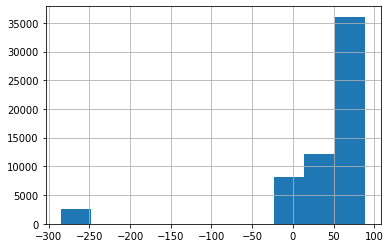

In [ ]:
df['AGE'].hist()

A number of measures were performed to protect patient privacy. Quoting from [MIMIC-III's documentation](https://mimic.physionet.org/mimicdata/time/), 

> All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future.

> Dates of birth which occur in the present time are not true dates of birth. Furthermore, dates of birth which occur before the year 1900 occur if the patient is older than 89. In these cases, the patient’s age at their first admission has been fixed to 300.

In other words, all patients with a negative 'age' calculated above are older than 89. For illustration, let's simply set them to be 90.

In [ ]:
df.loc[df['AGE'] < 0, 'AGE'] = 90

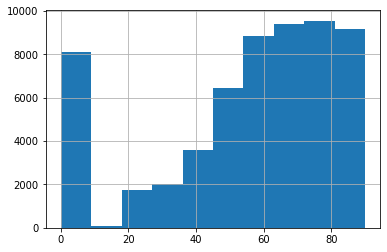

In [ ]:
df['AGE'].hist()

Now, the ~8,000 admissions centered around 0 refers to newborns.

### Encoding for Categorical Variables (Converting)

Categorical variables contains text which usually cannot be directly used as model inputs. We have to convert them using either *Label encoding* or *one-hot encoding*. *Label encoding* represents each category as a distinct number, whereas one-hot coding represents each category as multiple binary variables, spanning across multiple columns.

![encodings](https://miro.medium.com/max/3000/0*T5jaa2othYfXZX9W.)

As a rule of thumb, *one-hot encoding* is better in most cases so that the machine learning model would not treat the encoded values as numerical features. However, tree-based model such as random forest can work with label encoding. 

To perform one-hot encoding, I recommend using the `get_dummies()` function from pandas.

For label encoding, we can apply the Scikit-Learn package and use `LabelEncoder()`.

`ADMISSION_TYPE`

In [ ]:
tmp_df_admissions = pd.get_dummies(df['ADMISSION_TYPE'], prefix = 'ADMISSION_TYPE')
tmp_df_admissions

,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
58971,0,1,0,0
58972,0,1,0,0
58973,0,1,0,0
58974,0,1,0,0


In [ ]:
df = pd.concat([df, tmp_df_admissions], axis = 1) 
# add the above temporary dataframe to the original dataframe, axis = 1 specifies that we want to stack them horizontally not vertically

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SUBJECT_ID                58976 non-null  int64         
 1   HADM_ID                   58976 non-null  int64         
 2   ADMISSION_TYPE            58976 non-null  object        
 3   ADMITTIME                 58976 non-null  datetime64[ns]
 4   DISCHTIME                 58976 non-null  datetime64[ns]
 5   DEATHTIME                 5854 non-null   object        
 6   IN_HOSP_DEATH             58976 non-null  int64         
 7   DIAGNOSIS                 58951 non-null  object        
 8   MARITAL_STATUS            58976 non-null  object        
 9   INSURANCE                 58976 non-null  object        
 10  LANGUAGE                  58976 non-null  object        
 11  RELIGION                  58976 non-null  object        
 12  ETHNICITY         

`GENDER`

As the column only takes on two values 'M' and 'F', it is easier to simply do a logical operation and save the results as a new column. 

In [ ]:
df['GENDER'].value_counts()

M    32950
F    26026
Name: GENDER, dtype: int64

In [ ]:
df['GENDER_F'] = (df['GENDER'] == 'F') * 1

In [ ]:
df['GENDER_F'].value_counts()

0    32950
1    26026
Name: GENDER_F, dtype: int64

`RELIGION`

The column contains several categories but many of them have a limited sample size and thus may have a limited value for model training. We may retain the most prevalent categories and group the rest into an 'OTHERS' category before one-hot encoding.

In [ ]:
df['RELIGION'].value_counts()

CATHOLIC                  20606
NOT SPECIFIED             12211
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [ ]:
tmp_categories = list(df['RELIGION'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['RELIGION'].astype(tmp_categories_dtype).fillna('OTHERS') 
tmp_df = pd.get_dummies(tmp_df, prefix = 'RELIGION') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
58971,0,0,1,0
58972,0,0,0,1
58973,0,1,0,0
58974,0,1,0,0


Likewise, retain the top 3 categories for `INSURANCE`, `LANGUAGE`, `MARITAL STATUS` and `ETHNICITY`.

In [ ]:
tmp_categories = list(df['INSURANCE'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['INSURANCE'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'INSURANCE') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS
0,1,0,0,0
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
58971,0,1,0,0
58972,0,0,1,0
58973,0,1,0,0
58974,1,0,0,0


In [ ]:
tmp_categories = list(df['MARITAL_STATUS'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['MARITAL_STATUS'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'MARITAL_STATUS') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS
0,0,0,0,1
1,0,1,0,0
2,0,0,0,1
3,1,0,0,0
4,0,0,0,1
...,...,...,...,...
58971,0,0,1,0
58972,0,0,0,1
58973,1,0,0,0
58974,0,0,0,1


In [ ]:
tmp_categories = list(df['LANGUAGE'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['LANGUAGE'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'LANGUAGE') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
58971,0,0,0,1
58972,0,0,0,1
58973,0,0,0,1
58974,1,0,0,0


In [ ]:
tmp_categories = list(df['ETHNICITY'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['ETHNICITY'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'ETHNICITY') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
58971,0,0,1,0
58972,0,0,0,1
58973,1,0,0,0
58974,0,0,1,0


### Save your pre-processed dataframe 

When you are done with data preparation, it is highly recommended for you to save your resulting dataframe so that you do not need to go through all the preprocessing steps whenever you come back to work on it (or you lose internet connection). We can save and load datasets to/from your Google Drive.

First let's check the pre-processed dataframe. Yours may look differently if you altered the pre-processing steps.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   SUBJECT_ID                        58976 non-null  int64         
 1   HADM_ID                           58976 non-null  int64         
 2   ADMISSION_TYPE                    58976 non-null  object        
 3   ADMITTIME                         58976 non-null  datetime64[ns]
 4   DISCHTIME                         58976 non-null  datetime64[ns]
 5   DEATHTIME                         5854 non-null   object        
 6   IN_HOSP_DEATH                     58976 non-null  int64         
 7   DIAGNOSIS                         58951 non-null  object        
 8   MARITAL_STATUS                    58976 non-null  object        
 9   INSURANCE                         58976 non-null  object        
 10  LANGUAGE                          58976 non-nu

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,SINGLE,Government,ENGL,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,18,11.112500,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,70,13.895833,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,90,5.634722,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,76,5.585417,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0


Now we save the df to `mimic_in_hosp_death_clean.csv` with `to_csv()`

In [ ]:
# Grant access to your Google Drive. You would need to authenicate once again
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


In [ ]:
df.to_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv', index = False)

The file is now saved in your drive. Try running the following line to import it and make sure it works:

In [ ]:
pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

# if you want to save it as a variable, run this instead
# df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11 00:00:00,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.400000,0.000000,3.600000,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,0,MVA;TRAUMA,SINGLE,Government,ENGL,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,18,11.112500,0.000000,0.000000,0.750000,0.000000,34.000000,27.583333,0.000000,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2096-08-27 00:00:00,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,70,13.895833,0.000000,0.000000,0.571429,0.000000,41.000000,27.857143,0.000000,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29 00:00:00,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,90,5.634722,0.166667,5.000000,0.333333,1.333333,34.500000,0.000000,3.500000,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16 00:00:00,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,76,5.585417,0.000000,8.833333,1.000000,1.666667,63.000000,27.500000,0.000000,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,31355,146717,EMERGENCY,2110-07-28 22:03:00,2110-07-30 19:00:00,NaN,0,NECROTIZING PANCREATITIS,UNKNOWN (DEFAULT),Private,PTUN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,M,2071-09-27 00:00:00,0.8021,1.0,2,61.0,0.0,1.0,134.0,42.0,0.0,21.0,3,2.0,38,1.872917,0.500000,30.500000,0.000000,0.500000,67.000000,21.000000,0.000000,10.500000,1.500000,1.000000,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
58972,58016,105567,EMERGENCY,2118-10-08 20:59:00,2118-10-11 09:02:00,NaN,0,GALLSTONES,DIVORCED,Medicaid,PTUN,BUDDHIST,UNABLE TO OBTAIN,M,2070-06-16 00:00:00,2.0868,1.0,10,15.0,0.0,6.0,286.0,0.0,43.0,19.0,3,9.0,48,2.502083,0.333333,5.000000,0.000000,2.000000,95.333333,0.000000,14.333333,6.333333,1.000000,3.000000,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
58973,64255,145415,EMERGENCY,2151-11-05 22:32:00,2151-11-07 13:10:00,NaN,0,STATUS EPILEPTICUS,MARRIED,Private,PTUN,NOT SPECIFIED,WHITE,F,2118-09-12 00:00:0

## Exploratory data analysis



Now, let's have a closer look at the features we gathered.

In [ ]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'IN_HOSP_DEATH', 'DIAGNOSIS', 'MARITAL_STATUS',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'CALLOUT_COUNT', 'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT',
       'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT',
       'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT', 'AGE', 'LOS',
       'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
       'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
       'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
       'MICRO_COUNT_DAY', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'GENDER_F', 'RELIGION_CATHOLIC',
       'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS',
       'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid',
       'INSURANCE_OTHERS', 'MARITAL_

**Which features are (Text)Categorical**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

Categorical: ADMISSION_TYPE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY, GENDER
Text: ADMISSION_LOCATION, DISCHARGE_LOCATION, DIAGNOSIS

**Which features are numerical?** 

These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

Continous: callout_count, diag_count,prep_count, proc_count, cpt_count, lab_count,inputs_cv_count, inputs_mv_count, output_count, transfer_count, micro_count



### Prediction Target: `IN_HOSP_DEATH`

In [ ]:
df['IN_HOSP_DEATH'].value_counts()

0    53122
1     5854
Name: IN_HOSP_DEATH, dtype: int64

The overall in-hospital death rate is 5854 / (53122 + 5854) = 9.93% 

### Categorical features

We can calculate and visualize each feature by group. You may also apply statistical tests to see if there are significant differences between groups.

For simple visualizations in Python, the package [seaborn](https://seaborn.pydata.org/) may come in handy.

In [ ]:
# visualization package
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

`Gender`



The mean mortal value of each gender group

In [ ]:
df[['GENDER', 'IN_HOSP_DEATH']].groupby(['GENDER']).mean()

,IN_HOSP_DEATH
GENDER,
F,0.103742
M,0.095721


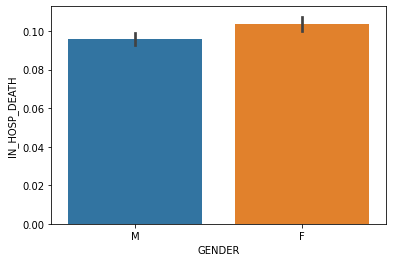

In [ ]:
sns.barplot(x = 'GENDER', y = 'IN_HOSP_DEATH', data = df)

`ADMITTION_TYPE`

In [ ]:
df[['ADMISSION_TYPE', 'IN_HOSP_DEATH']].groupby(['ADMISSION_TYPE']).mean()

,IN_HOSP_DEATH
ADMISSION_TYPE,
ELECTIVE,0.025564
EMERGENCY,0.129163
NEWBORN,0.007885
URGENT,0.120509


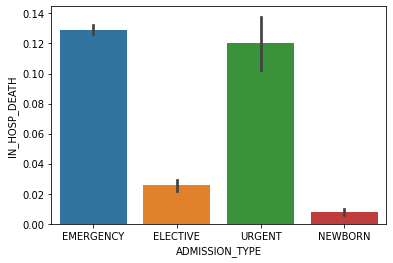

In [ ]:
sns.barplot(x = 'ADMISSION_TYPE', y = 'IN_HOSP_DEATH', data = df)

`MARITAL_STATUS`

In [ ]:
df[['MARITAL_STATUS', 'IN_HOSP_DEATH']].groupby(['MARITAL_STATUS']).mean()

,IN_HOSP_DEATH
MARITAL_STATUS,
DIVORCED,0.099284
LIFE PARTNER,0.000000
MARRIED,0.107678
SEPARATED,0.094571
SINGLE,0.082390
UNKNOWN (DEFAULT),0.069321
WIDOWED,0.146027


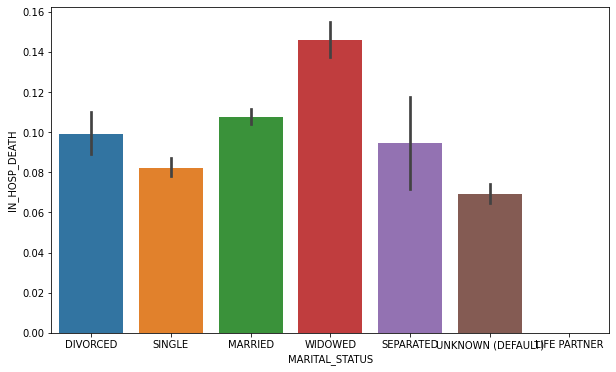

In [ ]:
plt.figure(figsize = (10, 6)) # adjust the size of your plots, formatted as (width, height)
sns.barplot(x = 'MARITAL_STATUS', y = 'IN_HOSP_DEATH', data = df)

**Exercise**: Replicate the above with `INSURANCE`.

It is also possible to visualize more variables within one plot.

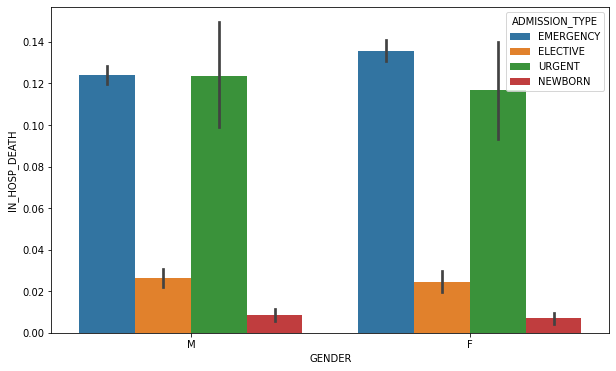

In [ ]:
plt.figure(figsize = (10, 6))
sns.barplot(x = 'GENDER', y = 'IN_HOSP_DEATH', hue = 'ADMISSION_TYPE', data = df)

### Numerical features

In [ ]:
df.describe()

,SUBJECT_ID,HADM_ID,IN_HOSP_DEATH,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
count,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000
mean,33755.583288,149970.809584,0.099261,5.130281,0.584967,11.039185,70.476974,4.071063,9.718292,377.187907,296.820164,61.363792,73.663507,4.440739,10.711578,54.682990,10.133916,0.087932,8.109976,0.543624,0.921930,38.068683,20.945233,5.644189,6.379781,0.753440,1.003296,0.130663,0.713358,0.133325,0.022653,0.441298,0.349396,0.207050,0.140210,0.303344,0.478415,0.382902,0.098091,0.040593,0.410998,0.224735,0.177581,0.186686,0.922714,0.018363,0.013395,0.045527,0.695130,0.092241,0.076692,0.135937
std,28092.726225,28883.095213,0.299014,10.037757,0.700514,6.466180,75.216818,3.884176,16.597424,502.867934,924.905379,221.981380,142.899052,1.843467,21.034618,27.111229,12.456682,0.130159,6.681174,0.711198,0.876012,27.438760,43.226989,13.385931,6.171553,0.585915,2.038059,0.337035,0.452197,0.339929,0.148797,0.496546,0.476783,0.405195,0.347207,0.459706,0.499538,0.486099,0.297440,0.197347,0.492019,0.417412,0.382163,0.389663,0.267046,0.134263,0.114961,0.208459,0.460356,0.289368,0.266105,0.342724
min,2.000000,100001.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.945139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11993.750000,124952.750000,0.000000,1.085875,0.000000,6.000000,21.000000,1.000000,0.000000,117.000000,0.000000,0.000000,10.000000,3.000000,1.000000,43.000000,3.743750,0.000000,4.038462,0.200000,0.000000,24.875000,0.000000,0.000000,1.600000,0.363636,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24133.500000,149989.500000,0.000000,2.104400,0.000000,9.000000,54.000000,3.000000,5.000000,235.000000,14.000000,0.000000,32.000000,4.000000,3.000000,61.000000,6.467014,0.000000,7.767594,0.376389,0.889899,35.400000,2.500000,0.000000,4.781929,0.600000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,5

`sns.histplot()` is a good alternative to `Series.hist()` that offers much more flexibility.

Using `Age` as an example,

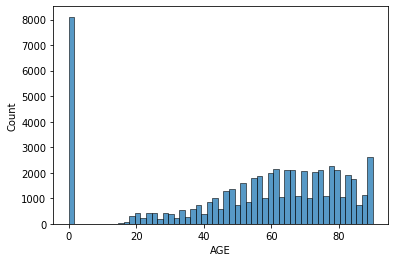

In [ ]:
sns.histplot(x = 'AGE', data = df)

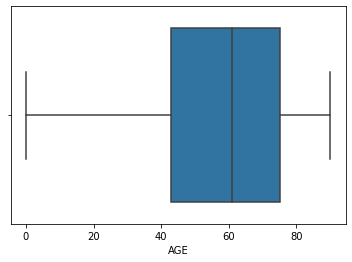

In [ ]:
sns.boxplot(x = 'AGE', data = df)

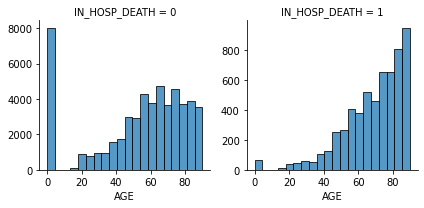

In [ ]:
g = sns.FacetGrid(df, col = 'IN_HOSP_DEATH', sharey = False)
g.map(sns.histplot, 'AGE', bins = 20)

**Discussion**: 

* What are the findings from the figure above?
* Based on the figure above, shall we remove the infants (e.g. `AGE` < 1) from our training dataset?

`DIAG_COUNT`

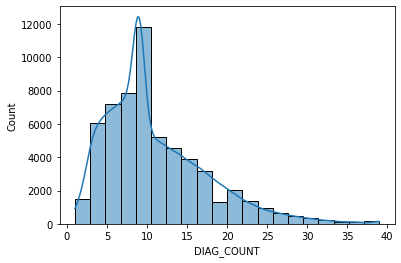

In [ ]:
sns.histplot(x = 'DIAG_COUNT', data = df, bins = 20, kde = True) # kde = True adds a smoothed line

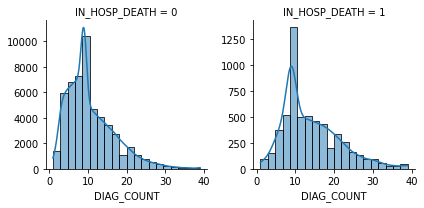

In [ ]:
g = sns.FacetGrid(df, col = 'IN_HOSP_DEATH', sharey = False)
g.map(sns.histplot, 'DIAG_COUNT', bins = 20, kde = True)

As a reference for you, the following code plots a distributions of all numerical features for the two patient groups.

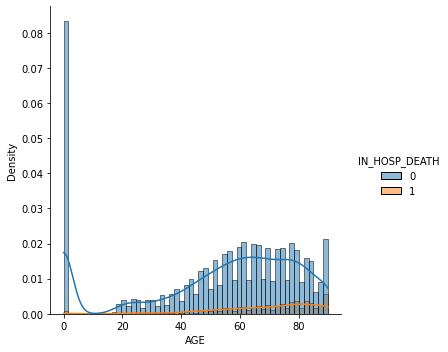

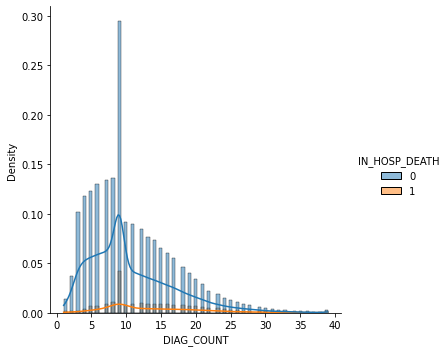

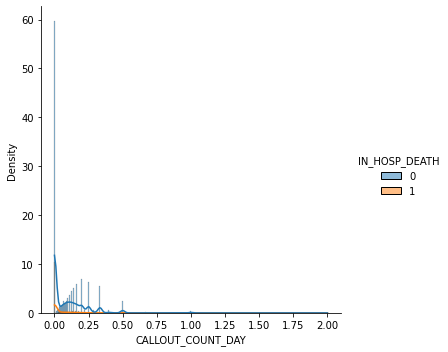

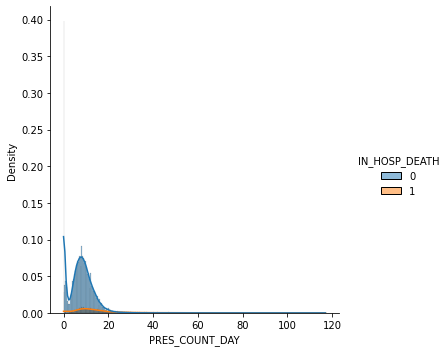

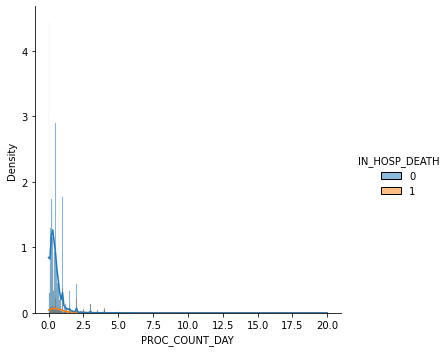

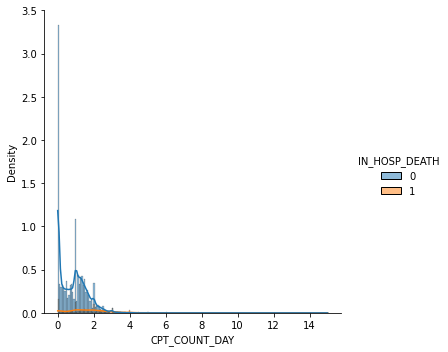

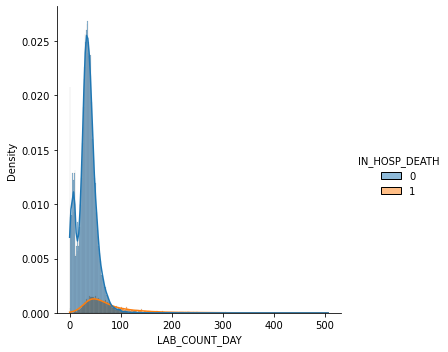

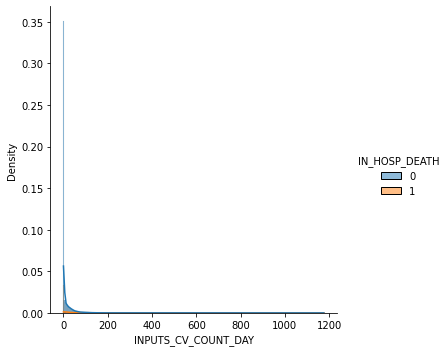

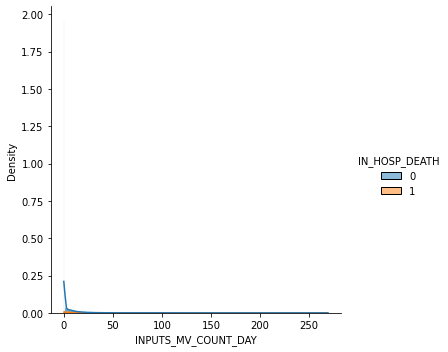

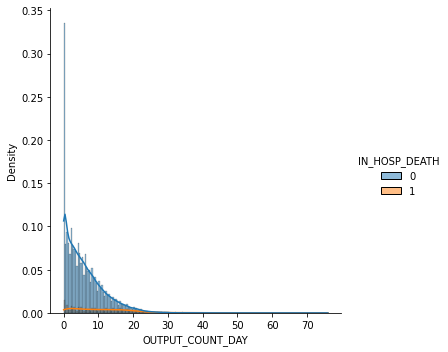

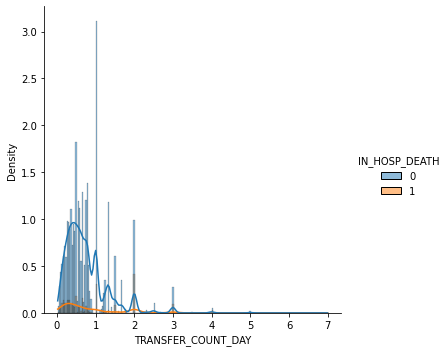

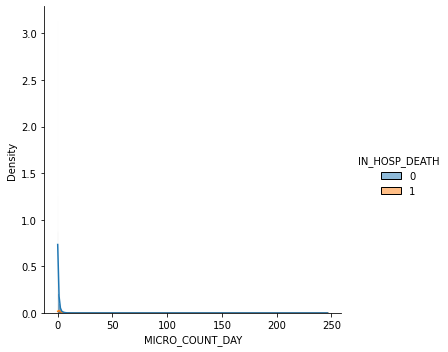

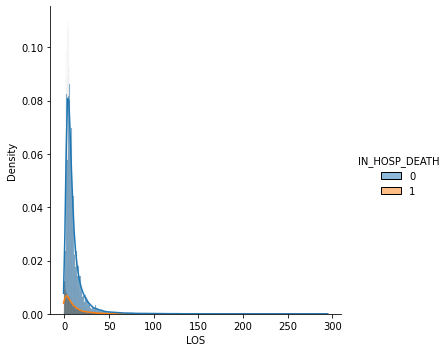

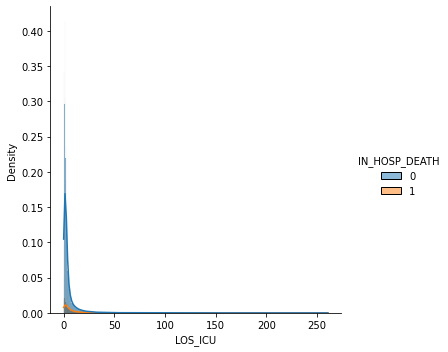

In [ ]:
numerical_feaures = ['AGE', 'DIAG_COUNT', 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 
                     'PROC_COUNT_DAY', 'CPT_COUNT_DAY', 'LAB_COUNT_DAY',
                     'INPUTS_CV_COUNT_DAY', 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 
                     'TRANSFER_COUNT_DAY', 'MICRO_COUNT_DAY', 'LOS', 'LOS_ICU']

for col_name in numerical_feaures:
  sns.displot(data = df, x = col_name, hue = 'IN_HOSP_DEATH', stat = 'density', kde = True)
  plt.show()

# References

* [7 Steps to Machine Learning: How to Prepare for an Automated Future](https://medium.com/dataseries/7-steps-to-machine-learning-how-to-prepare-for-an-automated-future-78c7918cb35d)
* [What is One Hot Encoding and How to Do It](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179)

<!--
## Discussion

How well will the model above translate into a decision support system in practice? Here are some issues you may think about (which is beyond the scope of training machine learning models itself):

* What is the purpose of the model? Is it in line with the goals and focuses of clinicians? 
* Suppose we trained a reasonably reliable model. What are the associated interventions could be done based on the model predictions?
* Consider the time of which the variables becomes available. Could the model deliver the predictions in a timely manner? Can this be improved? 
-->